In [2]:
import numpy as np
import pandas as pd

df_features = pd.read_parquet("data/features_d002.parquet")
df_label = pd.read_parquet("data/label_d002.parquet")
print(df_label.shape)
df_label.head()

(715680, 5)


,close,ret,trgt,bin,side
index,,,,,
2021-01-01 00:00:00+00:00,29016.23,NaN,NaN,0.0,0.0
2021-01-01 00:03:00+00:00,28965.02,NaN,NaN,0.0,0.0
2021-01-01 00:06:00+00:00,28928.06,NaN,NaN,0.0,0.0
2021-01-01 00:09:00+00:00,28851.82,NaN,NaN,0.0,0.0
2021-01-01 00:12:00+00:00,28786.75,NaN,NaN,0.0,0.0


In [3]:
meta_mask = df_label["ret"].notna().tolist()
side_mask = (df_label["side"].astype(int) != 0).tolist()

meta_label = df_label[meta_mask]["bin"].astype(np.int8).reset_index(drop=True)
meta_label.name = "label"
side_label = (
    (df_label[side_mask]["side"].astype(int) == 1)
    .astype(np.int8)
    .reset_index(drop=True)
)
side_label.name = "label"

meta_features = df_features[meta_mask].reset_index(drop=True)
side_features = df_features[side_mask].reset_index(drop=True)

assert meta_features.shape[0] == meta_label.shape[0]
assert side_features.shape[0] == side_label.shape[0]

# invalid_len = 300
# meta_features = meta_features.iloc[invalid_len:]
# meta_label = meta_label.iloc[invalid_len:]
# side_features = side_features.iloc[invalid_len:]
# side_label = side_label.iloc[invalid_len:]

# meta_split = int(meta_features.shape[0] * 0.8)
# side_split = int(side_features.shape[0] * 0.8)

# meta_x_train = meta_features.iloc[:meta_split]
# meta_x_test = meta_features.iloc[meta_split:]
# meta_y_train = meta_label.iloc[:meta_split]
# meta_y_test = meta_label.iloc[meta_split:]

# assert meta_x_train.shape[0] == meta_y_train.shape[0]
# assert meta_x_test.shape[0] == meta_y_test.shape[0]

# side_x_train = side_features.iloc[:side_split]
# side_x_test = side_features.iloc[side_split:]
# side_y_train = side_label.iloc[:side_split]
# side_y_test = side_label.iloc[side_split:]

# assert side_x_train.shape[0] == side_y_train.shape[0]
# assert side_x_test.shape[0] == side_y_test.shape[0]

In [4]:
meta_label.value_counts()

label
1    277306
0    256781
Name: count, dtype: int64

In [6]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=meta_features.shape[1] // 2,
    scoring="f1",
    cv=5,
    regression=False,
    n_jobs=-1,
)
sel.fit(meta_features, meta_label)

MRMR(cv=5, max_features=631, method='FCQ', n_jobs=-1, scoring='f1')

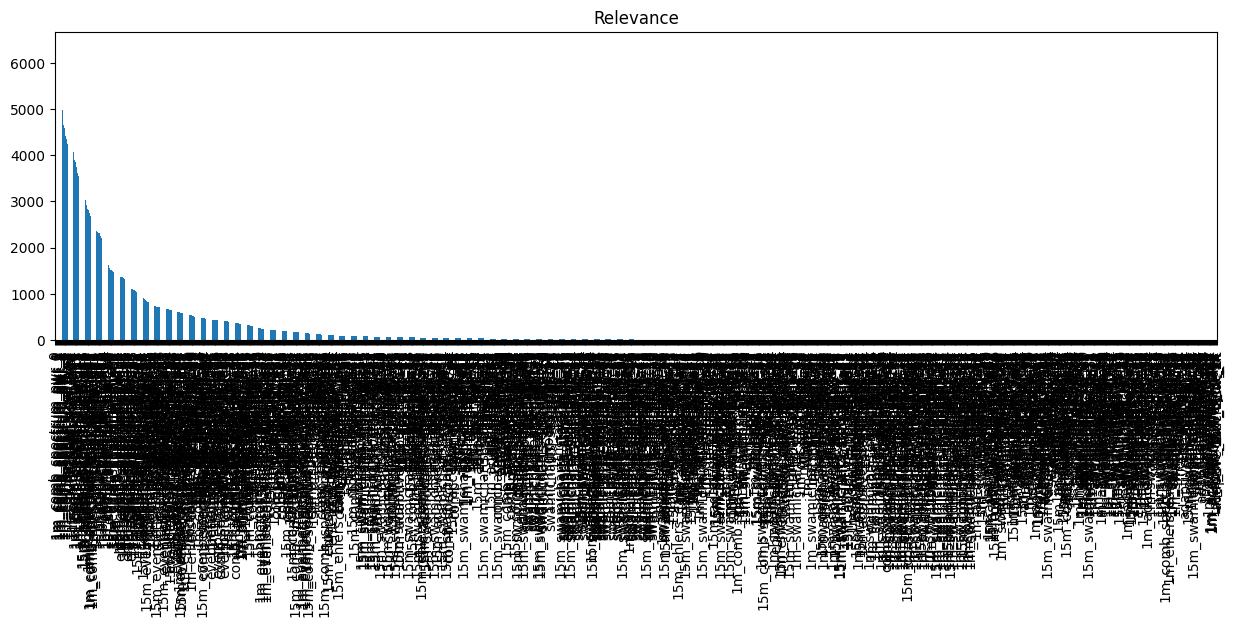

In [7]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [8]:
res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
res

comb_spectrum_pwr_0       6347.441700
1m_comb_spectrum_pwr_0    6131.410328
1m_comb_spectrum_pwr_1    5885.388471
comb_spectrum_pwr_1       5726.299363
1m_comb_spectrum_pwr_2    5660.376750
                             ...     
1m_acc_swing_index           0.000209
1m_swamicharts_rsi_13        0.000134
1m_dft_dom_cycle_dt          0.000032
15m_conv_14                  0.000015
adaptive_stochastic_dt       0.000003
Length: 1263, dtype: float64

In [9]:
import json

with open("data/mrmr_meta_features.json", "w") as f:
    json.dump(res.to_dict(), f)

In [10]:
# side feature selection
side_sel = MRMR(
    method="FCQ",
    max_features=meta_features.shape[1] // 2,
    scoring="f1",
    cv=5,
    regression=False,
    n_jobs=-1,
)
side_sel.fit(side_features, side_label)

MRMR(cv=5, max_features=631, method='FCQ', n_jobs=-1, scoring='f1')

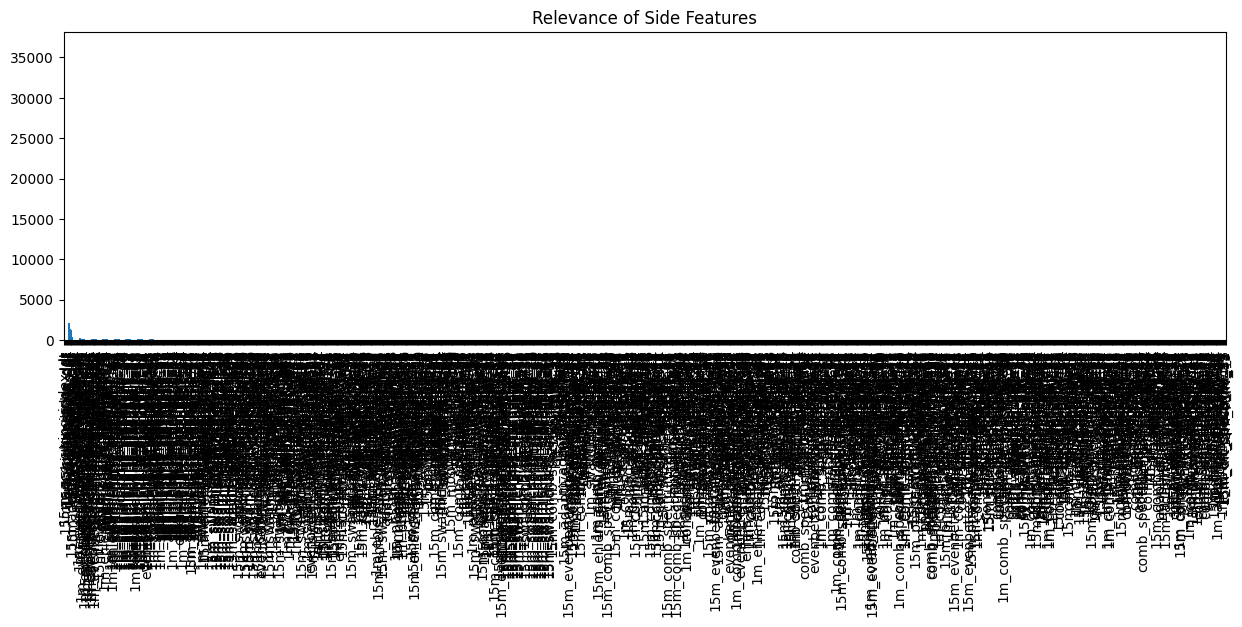

In [13]:
import matplotlib.pyplot as plt

pd.Series(side_sel.relevance_, index=side_sel.variables_).sort_values(
    ascending=False
).plot.bar(figsize=(15, 4))
plt.title("Relevance of Side Features")
plt.show()

In [14]:
side_res = pd.Series(side_sel.relevance_, index=side_sel.variables_).sort_values(
    ascending=False
)
side_res

15m_acc_swing_index_dt     36320.451430
15m_acc_swing_index_ddt    22511.848967
15m_bandpass_ddt            7206.276048
15m_highpass_bp_ddt         6784.868201
15m_roofing_filter_ddt      3507.327871
                               ...     
1m_swamicharts_rsi_15          0.000072
15m_dft_spectrum_19            0.000059
acp_pwr_8                      0.000034
15m_dft_spectrum_32            0.000018
15m_conv_43                    0.000002
Length: 1263, dtype: float64

In [15]:
import json

with open("data/mrmr_side_features.json", "w") as f:
    json.dump(side_res.to_dict(), f)